# Анализ рекламных источников игры «Космические братья»

## Общая информация об исследовании 

Цель исследования:

Анализ различий в поведении игроков пришедших в игру из разных источников.

Исходные данные:

Основной датасет `game_actions.csv` - данные о действиях игроков на первом уровне , где

- `event_datetime` — время события;
- `event` — одно из трёх событий:
 - `building` — объект построен,
 - `finished_stage_1` — первый уровень завершён,
 - `project` — проект завершён;
- `building_type` — один из трёх типов здания:
 - `assembly_shop` — сборочный цех,
 - `spaceport` — космопорт,
 - `research_center` — исследовательский центр;
- `user_id` — идентификатор пользователя;
- `project_type` — тип реализованного проекта;
 

Дополнительные датасеты:
 `ad_cost.csv`, где

- `day` - день, в который был совершен клик по объявлению
- `source` - источник трафика
- `cost` - стоимость кликов

 и датасет `user_source.csv` , где 

- `user_id` - идентификатор пользователя
- `source` - источник, с которого пришёл пользователь, установивший приложение


## Декомпозиция задачи (план работы)

- Изучение и предобработка данных:
  - загрузка и общее ознакомление с данными;
  - проверка наличия дубликатов, пропусков, их изучение и корректировка при необходимости;
  - изучение и изменение типов данных. 
- Исследовательский анализ данных:
  - пополнение данных из дополнительных датасетов;
  - проверка данных на достоверность, наличие аномалий и корректировка при необходимости;
  - изучение взаимосвязей данных.
- Исследование поведения пользователей в разрезе рекламных источников:
  - исследование распределения пользовтелей по рекламным источникам;
  - исследование активности пользователей в зависимости от рекламного источника;
  - исследование порядка прохождения уровня игроком в зависимости от рекламного источника;
- Проверка статистических гипотез:
  - проверка гипотезы о различии времени прохождения уровня путем разработки проекта или путем победы над противником;
  - выдвижение и проверка собственной гипотезы на основе полученных результатов исследовательского анализа
- Выводы, презентация, рекомендации.

In [1]:
# блок импорта библиотек
import pandas as pd
import numpy as np
import datetime as dt
import seaborn as sns
#!pip install seaborn -U
import matplotlib.pyplot as plt
from scipy import stats as st

# количество и ширина отображаемых столбцов
pd.options.display.max_columns = 200
pd.options.display.max_colwidth = 200

## Предобработка и исследовательский анализ данных 

###  game_actions.csv

Загрузим датафреймы с помощью конструкции try-except, чтобы можно было работать с проектом как на платформе Я.Практикума, так и локально.

In [2]:
# читаем файл game_actions.csv одновременно преобразуя тип поля содержащего даты
try:
    game_actions = pd.read_csv('/datasets/game_actions.csv', parse_dates=['event_datetime'])
except:
    game_actions = pd.read_csv('game_actions.txt', parse_dates=['event_datetime'])

In [3]:
# смотрим датафрейм
game_actions.info()
game_actions.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 135640 entries, 0 to 135639
Data columns (total 5 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   event_datetime  135640 non-null  datetime64[ns]
 1   event           135640 non-null  object        
 2   building_type   127957 non-null  object        
 3   user_id         135640 non-null  object        
 4   project_type    1866 non-null    object        
dtypes: datetime64[ns](1), object(4)
memory usage: 5.2+ MB


,event_datetime,event,building_type,user_id,project_type
0,2020-05-04 00:00:01,building,assembly_shop,55e92310-cb8e-4754-b622-597e124b03de,NaN
1,2020-05-04 00:00:03,building,assembly_shop,c07b1c10-f477-44dc-81dc-ec82254b1347,NaN
2,2020-05-04 00:00:16,building,assembly_shop,6edd42cc-e753-4ff6-a947-2107cd560710,NaN
3,2020-05-04 00:00:16,building,assembly_shop,92c69003-d60a-444a-827f-8cc51bf6bf4c,NaN
4,2020-05-04 00:00:35,building,assembly_shop,cdc6bb92-0ccb-4490-9866-ef142f09139d,NaN


In [4]:
# посмотрим на основные данные
game_actions.describe()

<ipython-input-4-9de5e650eaca>:2: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  game_actions.describe()


,event_datetime,event,building_type,user_id,project_type
count,135640,135640,127957,135640,1866
unique,128790,3,3,13576,1
top,2020-05-09 08:39:32,building,spaceport,d6aca06a-cd75-4cd8-b8cd-240a3c163884,satellite_orbital_assembly
freq,4,127957,59325,22,1866
first,2020-05-04 00:00:01,NaN,NaN,NaN,NaN
last,2020-06-05 12:32:49,NaN,NaN,NaN,NaN


Как видим, данные предоставлены примерно за один месяц - с полуночи 4 мая 2020 до полудня 5 июня 2020.

В игре замечены 13576 уникальных игроков.

Выделены наиболее часто встречающиеся значения и их количества в датафрейме. 

#### Обработка  дубликатов

In [5]:
# проверим датафрейм на наличие дубликатов
game_actions.duplicated().sum()

1

In [6]:
# посмотрим на дубликаты
game_actions.loc[game_actions.duplicated(keep=False)]

,event_datetime,event,building_type,user_id,project_type
74890,2020-05-10 18:41:56,building,research_center,c9af55d2-b0ae-4bb4-b3d5-f32aa9ac03af,NaN
74891,2020-05-10 18:41:56,building,research_center,c9af55d2-b0ae-4bb4-b3d5-f32aa9ac03af,NaN


Как видим записи действительно идентичны. Возможно произошел сбой при выгрузке или копировании. Удалим дубликат и проверим результат.

In [7]:
# удаляем дубликаты
game_actions.drop_duplicates(inplace=True)

print('Количество дубликатов = ',game_actions.duplicated().sum())
print()

# смотрим результат
game_actions.info()

Количество дубликатов =  0

<class 'pandas.core.frame.DataFrame'>
Int64Index: 135639 entries, 0 to 135639
Data columns (total 5 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   event_datetime  135639 non-null  datetime64[ns]
 1   event           135639 non-null  object        
 2   building_type   127956 non-null  object        
 3   user_id         135639 non-null  object        
 4   project_type    1866 non-null    object        
dtypes: datetime64[ns](1), object(4)
memory usage: 6.2+ MB


#### Обработка пропусков

Наблюдаем пропуски в столбцах `building_type` и `project_type`. Необходимо рассмотреть эти столбцы подробнее.

Предположим, что событие `project` однозначно соответствует  значению `satellite_orbital_assembly` в столбце `project_type`

In [8]:
# проверим значения, которые имеются в столбце project_type
game_actions['project_type'].unique()

array([nan, 'satellite_orbital_assembly'], dtype=object)

In [9]:
# проверка условия
game_actions.query('event == "project" & project_type != "satellite_orbital_assembly"')

,event_datetime,event,building_type,user_id,project_type


In [10]:
# проверка условия
game_actions.query('event != "project" & project_type == "satellite_orbital_assembly"')

,event_datetime,event,building_type,user_id,project_type


In [11]:
# проверка условия
game_actions.query('project_type == "satellite_orbital_assembly"')['event'].unique()

array(['project'], dtype=object)

Действительно, событие `project` однозначно соответствует значению `satellite_orbital_assembly` в столбце `project_type`. Отсюда вывод, что пропуски в столбце `project_type` свидетельствуют о незаконченности создания проекта, 

а значение события  `project` - однозначно свидетельствует об окончании уровня завершением проекта.
Итак, об окончании проекта можно судить по столбцу `event`. Столбец `project_type`в этом смысле никакой дополнительной информации не несет.

Удалим столбец `project_type`, т.к. для нашего исследования в нем нет необходимостин

In [12]:
# удалим столбец `project_type`
game_actions = game_actions.drop('project_type', axis=1)

# смотрим результат
game_actions.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 135639 entries, 0 to 135639
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   event_datetime  135639 non-null  datetime64[ns]
 1   event           135639 non-null  object        
 2   building_type   127956 non-null  object        
 3   user_id         135639 non-null  object        
dtypes: datetime64[ns](1), object(3)
memory usage: 5.2+ MB


Далее предположим, что пропуски в столбце `building_type` имеются в тех строках, где событие не является постройкой здания. Проверим это.

In [13]:
# проверяем уникальные значения столбца 'building_type' при условии, что событие -  постройка здания
game_actions.query('event == "building"')['building_type'].unique()

array(['assembly_shop', 'spaceport', 'research_center'], dtype=object)

In [14]:
# проверяем уникальные значения столбца 'building_type' при условии, что событие - не постройка здания
game_actions.query('event != "building"')['building_type'].unique()


array([nan], dtype=object)

In [15]:
# проверяем уникальные значения столбца 'event' при условии, что событие - завершение уровня
game_actions.query('event == "finished_stage_1"')['building_type'].unique()

array([nan], dtype=object)

Действительно, так и есть - пропуски в столбце `building_type` имеются в тех строках, где событие не является постройкой здания. Заменим пропуски в этом столбце на значением 'no_bilding'

In [16]:
game_actions['building_type'] = game_actions['building_type'].fillna('no_bilding')

# смотрим результат

display(game_actions['building_type'].unique())
game_actions.info()
game_actions.head()

array(['assembly_shop', 'spaceport', 'no_bilding', 'research_center'],
      dtype=object)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 135639 entries, 0 to 135639
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   event_datetime  135639 non-null  datetime64[ns]
 1   event           135639 non-null  object        
 2   building_type   135639 non-null  object        
 3   user_id         135639 non-null  object        
dtypes: datetime64[ns](1), object(3)
memory usage: 5.2+ MB


,event_datetime,event,building_type,user_id
0,2020-05-04 00:00:01,building,assembly_shop,55e92310-cb8e-4754-b622-597e124b03de
1,2020-05-04 00:00:03,building,assembly_shop,c07b1c10-f477-44dc-81dc-ec82254b1347
2,2020-05-04 00:00:16,building,assembly_shop,6edd42cc-e753-4ff6-a947-2107cd560710
3,2020-05-04 00:00:16,building,assembly_shop,92c69003-d60a-444a-827f-8cc51bf6bf4c
4,2020-05-04 00:00:35,building,assembly_shop,cdc6bb92-0ccb-4490-9866-ef142f09139d


Итак, мы определили, что означают пропуски в столбцах датафрейма и удалили или заполнили их.

### ad_costs.csv

- day - день, в который был совершен клик по объявлению
- source - источник трафика
- cost - стоимость кликов

In [17]:
# читаем файл ad_costs.csv
try:
    ad_costs = pd.read_csv('/datasets/ad_costs.csv', parse_dates=['day'])
except:
    ad_costs = pd.read_csv('ad_costs.csv', parse_dates=['day'])

In [18]:
# смотрим датафрейм
ad_costs.info()
ad_costs.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28 entries, 0 to 27
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   source  28 non-null     object        
 1   day     28 non-null     datetime64[ns]
 2   cost    28 non-null     float64       
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 800.0+ bytes


,source,day,cost
0,facebook_ads,2020-05-03,935.882786
1,facebook_ads,2020-05-04,548.354480
2,facebook_ads,2020-05-05,260.185754
3,facebook_ads,2020-05-06,177.982200
4,facebook_ads,2020-05-07,111.766796


In [19]:
# изменим формат столбца сost округлив до двух знаков после запятой
ad_costs['cost'] = ad_costs['cost'].round(2)

In [20]:
# оценим период в который происходили переходы с рекламных источников
#ad_costs['day'] = pd.to_datetime(ad_costs['day'])
ad_costs['day'].describe()

<ipython-input-20-038d7492a728>:3: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  ad_costs['day'].describe()


count                      28
unique                      7
top       2020-05-08 00:00:00
freq                        4
first     2020-05-03 00:00:00
last      2020-05-09 00:00:00
Name: day, dtype: object

Итак, судя по данному датасету, переходы пользователей предоставлены за период с  03 мая по 09 мая 2020 года, что не совпадает с периодом  данных о действиях игроков по датам.

In [21]:
# проверим датафрейм на наличие дубликатов
ad_costs.duplicated().sum()

0

итак, пропусков и дубликатов нет

In [22]:
# список рекламных источников
list_ad_costs = ad_costs['source'].unique().tolist()
display(list_ad_costs)

['facebook_ads',
 'instagram_new_adverts',
 'yandex_direct',
 'youtube_channel_reklama']

### user_source.csv

- user_id - идентификатор пользователя
- source - источник, с которого пришёл пользователь, установивший приложение

In [23]:
# читаем файл user_source.csv
try:
    user_source = pd.read_csv('/datasets/user_source.csv')
except:
    user_source = pd.read_csv('user_source.csv')

In [24]:
# смотрим датафрейм
user_source.info()
user_source.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13576 entries, 0 to 13575
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  13576 non-null  object
 1   source   13576 non-null  object
dtypes: object(2)
memory usage: 212.2+ KB


,user_id,source
0,0001f83c-c6ac-4621-b7f0-8a28b283ac30,facebook_ads
1,00151b4f-ba38-44a8-a650-d7cf130a0105,yandex_direct
2,001aaea6-3d14-43f1-8ca8-7f48820f17aa,youtube_channel_reklama
3,001d39dc-366c-4021-9604-6a3b9ff01e25,instagram_new_adverts
4,002f508f-67b6-479f-814b-b05f00d4e995,facebook_ads


In [25]:
# проверим датафрейм на наличие дубликатов среди user_id
user_source['user_id'].duplicated().sum()

0

Как видим, пропусков и дубликатов также нет. Все пользователи однозначно ассоциированы с рекламным источником.

In [26]:
# составим список рекламных источников
ads_list = user_source['source'].unique().tolist()
display(ads_list)

['facebook_ads',
 'yandex_direct',
 'youtube_channel_reklama',
 'instagram_new_adverts']

In [27]:
# сравним списки рекламных источников из дополнительных датасетов
if set(list_ad_costs) == set(ads_list):
    print('Списки рекламных источников совпадают')
else:
    print('Списки рекламных источников НЕ совпадают')

Списки рекламных источников совпадают


Дополним основной датафрейм из `user_source` рекламным источником, с которого зашел игрок

In [28]:
# присоединим рекламные источники 
game_actions = game_actions.merge(user_source, how='left')
game_actions.head()

,event_datetime,event,building_type,user_id,source
0,2020-05-04 00:00:01,building,assembly_shop,55e92310-cb8e-4754-b622-597e124b03de,youtube_channel_reklama
1,2020-05-04 00:00:03,building,assembly_shop,c07b1c10-f477-44dc-81dc-ec82254b1347,facebook_ads
2,2020-05-04 00:00:16,building,assembly_shop,6edd42cc-e753-4ff6-a947-2107cd560710,instagram_new_adverts
3,2020-05-04 00:00:16,building,assembly_shop,92c69003-d60a-444a-827f-8cc51bf6bf4c,facebook_ads
4,2020-05-04 00:00:35,building,assembly_shop,cdc6bb92-0ccb-4490-9866-ef142f09139d,yandex_direct


In [29]:
# извлечем из 'event_datetime' день и добавим в датафрейм поле 'day'
game_actions['day'] = game_actions['event_datetime'].dt.date

In [30]:
# просмотрим информацию по датафрейму
game_actions.info()
game_actions.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 135639 entries, 0 to 135638
Data columns (total 6 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   event_datetime  135639 non-null  datetime64[ns]
 1   event           135639 non-null  object        
 2   building_type   135639 non-null  object        
 3   user_id         135639 non-null  object        
 4   source          135639 non-null  object        
 5   day             135639 non-null  object        
dtypes: datetime64[ns](1), object(5)
memory usage: 7.2+ MB


,event_datetime,event,building_type,user_id,source,day
0,2020-05-04 00:00:01,building,assembly_shop,55e92310-cb8e-4754-b622-597e124b03de,youtube_channel_reklama,2020-05-04
1,2020-05-04 00:00:03,building,assembly_shop,c07b1c10-f477-44dc-81dc-ec82254b1347,facebook_ads,2020-05-04
2,2020-05-04 00:00:16,building,assembly_shop,6edd42cc-e753-4ff6-a947-2107cd560710,instagram_new_adverts,2020-05-04
3,2020-05-04 00:00:16,building,assembly_shop,92c69003-d60a-444a-827f-8cc51bf6bf4c,facebook_ads,2020-05-04
4,2020-05-04 00:00:35,building,assembly_shop,cdc6bb92-0ccb-4490-9866-ef142f09139d,yandex_direct,2020-05-04


### Вывод

Данные о событиях предоставлены примерно за один месяц - с полуночи 4 мая 2020 до полудня 5 июня 2020.

В игре замечены 13576 уникальных игроков.

Обнаружена одна строка-дубликат. Удалена.

Обработаны пропуски. Столбец `project_type` удален, как не несущий дополнительной информации. Пропуски в столбце `building_type` заполнены информацией.

Данные о переходах пользователей с рекламных источников предоставлены за период с 03 мая по 09 мая 2020 года, что не полностью совпадает по датам с периодом данных о действиях игроков.

Списки рекламных источников в дополнительных датасетах - совпадают.

## Исследование поведения пользователей в разрезе рекламных источников

### Ежедневная активность игроков (DAU)

Посмотрим, как распределены игроки по дням (в т.ч. в разрезе рекламных источников)

,day,source,n_users
0,2020-05-04,facebook_ads,1184
1,2020-05-04,instagram_new_adverts,1452
2,2020-05-04,yandex_direct,2078
3,2020-05-04,youtube_channel_reklama,1146
4,2020-05-05,facebook_ads,1328


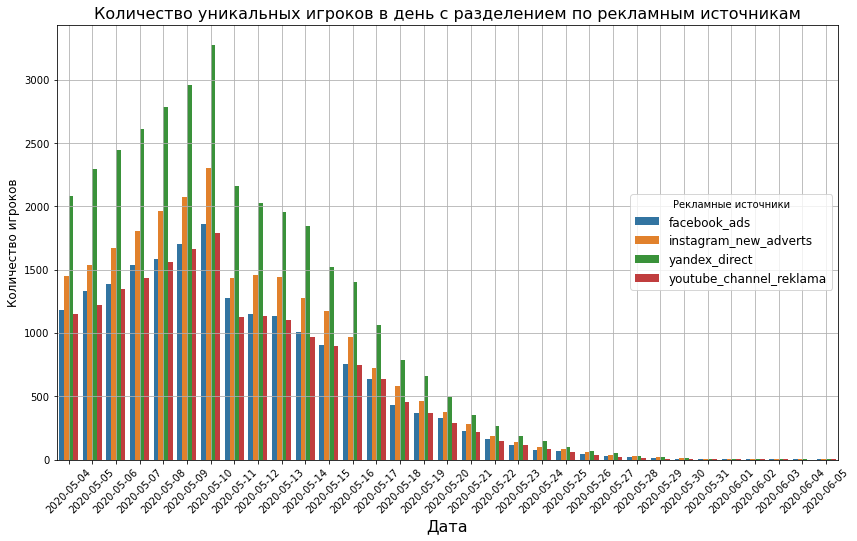

In [31]:
# сгруппируем пользователей по дням и рекламным источникам и посчитаем количество уникальных игроков
day_users = game_actions.groupby(['day','source']).agg({'user_id':'nunique'}).reset_index()
day_users.columns = ['day','source', 'n_users']

display(day_users.head())

# построим график
fig, ax = plt.subplots(figsize=(14, 8))

sns.barplot(data=day_users, x='day', y='n_users',hue='source')

plt.title("Количество уникальных игроков в день с разделением по рекламным источникам",fontsize=16) 
plt.ylabel("Количество игроков",fontsize=12) 
plt.xlabel("Дата",fontsize=16)
plt.xticks(rotation=45)
plt.grid('on')
plt.legend(title='Рекламные источники',loc='right',fontsize=12)

plt.show()

#### Вывод

Наблюдаем линейный рост количества уникальных игроков до 10 мая включительно, затем резкий (около трети игроков) спад с последующим снижением до практически до нуля.

Можно предположить, что спад активности игроков связан с окончанием праздничных дней, либо с тем, что прекратилась рекламная компания на рекламных источниках.

С другой стороны, по условию задачи:
- В датасете содержатся данные первых пользователей приложения — когорты пользователей, которые начали пользоваться приложением в период с 4 по 10 мая включительно;
- В датасете представлены данные по игре пользователей на первом уровне.

Следовательно, речь не идет о прекращении рекламной компании и мы можем предположить спад активности с 10 на 11 мая в связи с окончанием праздничных дней. НО, согласно производственному календарю http://www.consultant.ru/law/ref/calendar/proizvodstvennye/2020/  11 мая 2020 года был тоже нерабочий день. 

Остается предоположить, что к 11 мая значительная доля игроков рассматриваемой когорты просто закончила первый уровень. Проверим это предположение позже.

### Рекламные расходы по дням 

Посмотрим как распределились рекламные расходы по источникам

,day,source,cost
0,2020-05-03,facebook_ads,935.88
1,2020-05-03,instagram_new_adverts,943.20
2,2020-05-03,yandex_direct,969.14
3,2020-05-03,youtube_channel_reklama,454.22
4,2020-05-04,facebook_ads,548.35


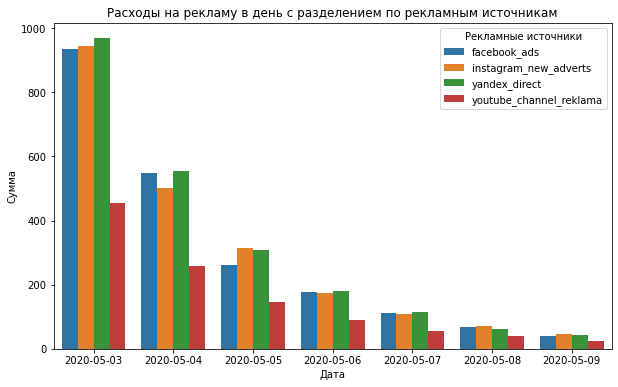

In [32]:
# посчитаем суммы расходов в день по рекламным источникам
ads_cost_grouped = ad_costs.groupby(['day','source']).sum().reset_index()
display(ads_cost_grouped.head())

# построим график рекламных расходов
ads_cost_grouped['day'] = ads_cost_grouped['day'].dt.date   # подписи оси х

fig, ax = plt.subplots(figsize=(10, 6))

sns.barplot(data=ads_cost_grouped, x='day', y='cost',hue='source')

plt.title("Расходы на рекламу в день с разделением по рекламным источникам") 
plt.ylabel("Сумма") 
plt.xlabel("Дата")
plt.legend(title='Рекламные источники',loc="best" )

plt.show()

#### Вывод

Как видим по всем рекламным источникам динамика сходная - наибольшее количество кликов в первые дни, далее наблюдаем гиперболическое снижение количества новых игроков.

### Стоимость привлечения одного игрока (САС)

Посмотрим, как распределились рекламные расходы на одного игрока в разрезе рекламных источников. Т.е. выясним стоимость привлечения одного игрока. 

In [33]:
# выделим информацию о датах событий и пользователях
events = game_actions[['event_datetime','event','user_id','source','day']].copy()
events.info()
events.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 135639 entries, 0 to 135638
Data columns (total 5 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   event_datetime  135639 non-null  datetime64[ns]
 1   event           135639 non-null  object        
 2   user_id         135639 non-null  object        
 3   source          135639 non-null  object        
 4   day             135639 non-null  object        
dtypes: datetime64[ns](1), object(4)
memory usage: 6.2+ MB


,event_datetime,event,user_id,source,day
0,2020-05-04 00:00:01,building,55e92310-cb8e-4754-b622-597e124b03de,youtube_channel_reklama,2020-05-04
1,2020-05-04 00:00:03,building,c07b1c10-f477-44dc-81dc-ec82254b1347,facebook_ads,2020-05-04
2,2020-05-04 00:00:16,building,6edd42cc-e753-4ff6-a947-2107cd560710,instagram_new_adverts,2020-05-04
3,2020-05-04 00:00:16,building,92c69003-d60a-444a-827f-8cc51bf6bf4c,facebook_ads,2020-05-04
4,2020-05-04 00:00:35,building,cdc6bb92-0ccb-4490-9866-ef142f09139d,yandex_direct,2020-05-04


In [34]:
# находим даты первого события для каждого игрока
first_event = events.sort_values(by='event_datetime').groupby('user_id').first().reset_index()
first_event.rename(columns={'event_datetime':'first_event'},inplace=True)
first_event['day'] = first_event['first_event'].dt.normalize()

first_event.info()
first_event.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13576 entries, 0 to 13575
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   user_id      13576 non-null  object        
 1   first_event  13576 non-null  datetime64[ns]
 2   event        13576 non-null  object        
 3   source       13576 non-null  object        
 4   day          13576 non-null  datetime64[ns]
dtypes: datetime64[ns](2), object(3)
memory usage: 530.4+ KB


,user_id,first_event,event,source,day
0,0001f83c-c6ac-4621-b7f0-8a28b283ac30,2020-05-06 01:07:37,building,facebook_ads,2020-05-06
1,00151b4f-ba38-44a8-a650-d7cf130a0105,2020-05-06 03:09:12,building,yandex_direct,2020-05-06
2,001aaea6-3d14-43f1-8ca8-7f48820f17aa,2020-05-05 18:08:52,building,youtube_channel_reklama,2020-05-05
3,001d39dc-366c-4021-9604-6a3b9ff01e25,2020-05-05 21:02:05,building,instagram_new_adverts,2020-05-05
4,002f508f-67b6-479f-814b-b05f00d4e995,2020-05-05 13:49:58,building,facebook_ads,2020-05-05
5,003b80c6-4164-4157-bb2a-03d0181d39c4,2020-05-04 09:10:22,building,yandex_direct,2020-05-04
6,003ee7e8-6356-4286-a715-62f22a18d2a1,2020-05-05 08:31:04,building,instagram_new_adverts,2020-05-05
7,004074f8-251a-4776-922c-8348dca1a2f6,2020-05-04 01:07:35,building,facebook_ads,2020-05-04
8,00440efd-aa50-4b4b-aae8-ffcd1782729d,2020-05-04 07:20:40,building,facebook_ads,2020-05-04
9,00464e5e-28ed-4be6-bf44-517ef7b3937b,2020-05-04 08:35:29,building,yandex_direct,2020-05-04


В процессе обсуждения предоставленных данных выяснилось, что необходимо считать первый вход пользователя в игру через рекламный источник на следующий день после показа рекламы.

In [35]:
# увеличим дату в файле рекламных расходов для синхронизации c первым событием пользователя
ads_cost_grouped['day'] = pd.to_datetime(ads_cost_grouped['day']) + dt.timedelta(days=1)

#
ads_cost_grouped.info()
ads_cost_grouped.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28 entries, 0 to 27
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   day     28 non-null     datetime64[ns]
 1   source  28 non-null     object        
 2   cost    28 non-null     float64       
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 800.0+ bytes


,day,source,cost
0,2020-05-04,facebook_ads,935.88
1,2020-05-04,instagram_new_adverts,943.20
2,2020-05-04,yandex_direct,969.14
3,2020-05-04,youtube_channel_reklama,454.22
4,2020-05-05,facebook_ads,548.35


In [36]:
# присоединим к датафрейму с первым событием информацию о расходах на рекламных источниках 
first_event_ads = first_event.merge(ads_cost_grouped, 
                                    left_on=['source','day'], 
                                    right_on=['source','day'], 
                                    how='left')
first_event_ads.head()

,user_id,first_event,event,source,day,cost
0,0001f83c-c6ac-4621-b7f0-8a28b283ac30,2020-05-06 01:07:37,building,facebook_ads,2020-05-06,260.19
1,00151b4f-ba38-44a8-a650-d7cf130a0105,2020-05-06 03:09:12,building,yandex_direct,2020-05-06,308.23
2,001aaea6-3d14-43f1-8ca8-7f48820f17aa,2020-05-05 18:08:52,building,youtube_channel_reklama,2020-05-05,259.07
3,001d39dc-366c-4021-9604-6a3b9ff01e25,2020-05-05 21:02:05,building,instagram_new_adverts,2020-05-05,502.93
4,002f508f-67b6-479f-814b-b05f00d4e995,2020-05-05 13:49:58,building,facebook_ads,2020-05-05,548.35


In [37]:
# сгруппируем пользователей по источникам и дате первого события
users_by_source = first_event_ads.groupby(['source','day']
                                    ).agg({'user_id': 'count',}).reset_index()
users_by_source.rename(columns={'user_id':'n_users'},inplace=True)

users_by_source.head()

,source,day,n_users
0,facebook_ads,2020-05-04,1184
1,facebook_ads,2020-05-05,694
2,facebook_ads,2020-05-06,345
3,facebook_ads,2020-05-07,224
4,facebook_ads,2020-05-08,139


In [38]:
users_by_source['n_users'].sum()

13576

In [39]:
# для расчета САС объединим датафреймы со стоимостью кликов в день  с количеством уникальных пользователей в день

report_by_sources = ads_cost_grouped.merge(users_by_source, 
                                    left_on=['source','day'], 
                                    right_on=['source','day'], 
                                    how='outer')

report_by_sources['cac'] = (report_by_sources['cost'] / report_by_sources['n_users']
                           ).round(2)
report_by_sources.head()


,day,source,cost,n_users,cac
0,2020-05-04,facebook_ads,935.88,1184,0.79
1,2020-05-04,instagram_new_adverts,943.20,1452,0.65
2,2020-05-04,yandex_direct,969.14,2078,0.47
3,2020-05-04,youtube_channel_reklama,454.22,1146,0.40
4,2020-05-05,facebook_ads,548.35,694,0.79


In [40]:
report_by_sources['n_users'].sum()

13576

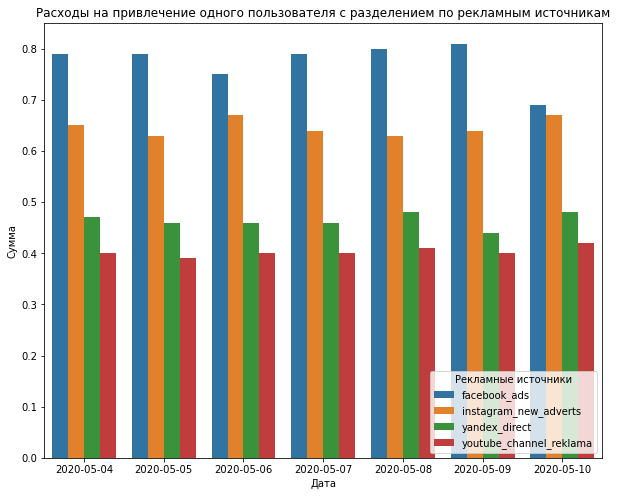

In [41]:
# построим график САС

fig, ax = plt.subplots(figsize=(10, 8))

report_by_sources['day'] = report_by_sources['day'].dt.strftime('%Y-%m-%d')  # для подписи оси х

sns.barplot(data=report_by_sources, x='day', y='cac',hue='source')

plt.title("Расходы на привлечение одного пользователя с разделением по рекламным источникам") 
plt.ylabel("Сумма") 
plt.xlabel("Дата")

plt.legend(title='Рекламные источники',loc="lower right" )

plt.show()

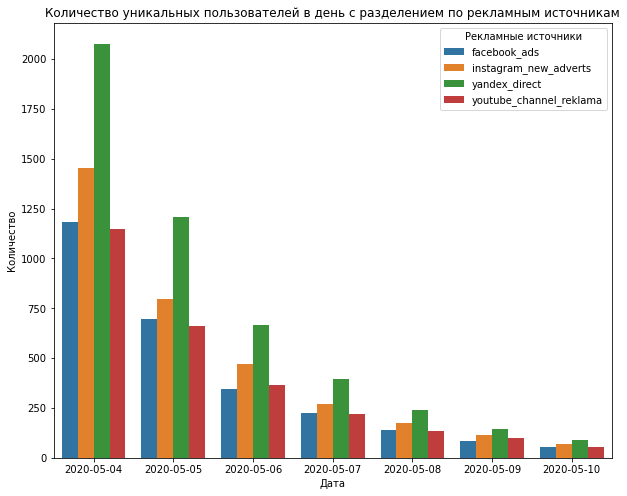

In [42]:
# построим график количества уникальных пользователей в день

fig, ax = plt.subplots(figsize=(10, 8))

users_by_source['day'] = users_by_source['day'].dt.strftime('%Y-%m-%d')  # для подписи оси х

sns.barplot(data=users_by_source, x='day', y='n_users',hue='source')

plt.title("Количество уникальных пользователей в день с разделением по рекламным источникам") 
plt.ylabel("Количество") 
plt.xlabel("Дата")

plt.legend(title='Рекламные источники',loc="best" )

plt.show()

Средняя стоимость привлечения одного клиента в целом по проекту : 0.56 у.е.

Средняя стоимость привлечения одного клиента по рекламным источникам :


,source,cac,ratio
0,facebook_ads,0.77,1.38
1,instagram_new_adverts,0.65,1.16
2,yandex_direct,0.46,0.82
3,youtube_channel_reklama,0.40,0.71
4,в среднем по всем источникам,0.56,1.00


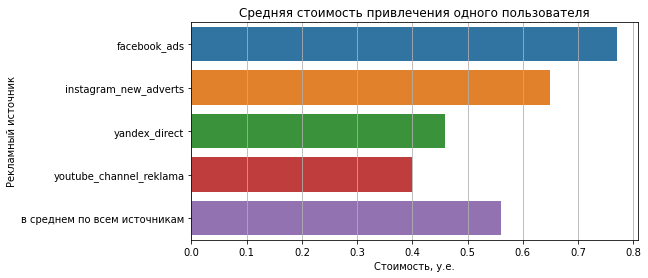

In [43]:
# сгруппируем таблицу по источникам и усредним САС по каждому
report_by_cac = report_by_sources.groupby(['source']
                                 ).agg({'cac':'mean'}).round(2).reset_index()

# рассчитаем САС в среднем по всем пользователям
cac_mean = (report_by_sources['cost'].sum() / report_by_sources['n_users'].sum()).round(2)
print('Средняя стоимость привлечения одного клиента в целом по проекту : {:.2f} у.е.'.format(cac_mean))

# дополним таблицу общим средним САС
cac_mean_row = {'source':'в среднем по всем источникам', 'cac':cac_mean}
report_by_cac = report_by_cac.append(cac_mean_row, ignore_index=True)

# отношение САС по рекламному источнику к среднему САС по проекту
report_by_cac['ratio'] = (report_by_cac['cac'] / cac_mean).round(2)

print('\nСредняя стоимость привлечения одного клиента по рекламным источникам :')
display(report_by_cac)

# график средних САС по источникам и вцелом
fig, ax = plt.subplots(figsize=(8, 4))
sns.barplot(data=report_by_cac, x='cac', y='source')
ax.xaxis.grid(True)

plt.title("Средняя стоимость привлечения одного пользователя") 
plt.ylabel("Рекламный источник") 
plt.xlabel("Стоимость, у.е.")
plt.show()


#### Вывод

Количество уникальных пользователей игры в указанном периоде снижается по гиперболе, при том, что стоимость привлечения одного игрока с изменением даты меняется незначительно.

Средняя стоимость привлечения одного игрока по проекту в целом составляет 0.56 у.е.

Средние значения САС по рекламе выше среднего по проекту вцелом в Facebook(+38%) и Instagram(+16%) , а САС Яндекса и YouTube ниже на 18% и 29% соответственно.

### Количество игроков 

Рассмотрим теперь поведение игроков - их количество, долю закончивших уровень, способ окончания уровня.  

In [44]:
# количество уникальных пользователей
n_users = len(game_actions['user_id'].unique())

print('За период с {} по {} в игре находилось {} уникальных игроков'
      .format(game_actions['event_datetime'].min(),
              game_actions['event_datetime'].max(),
              n_users ))

За период с 2020-05-04 00:00:01 по 2020-06-05 12:32:49 в игре находилось 13576 уникальных игроков


,source,n_user
0,facebook_ads,2726
1,instagram_new_adverts,3347
2,yandex_direct,4817
3,youtube_channel_reklama,2686


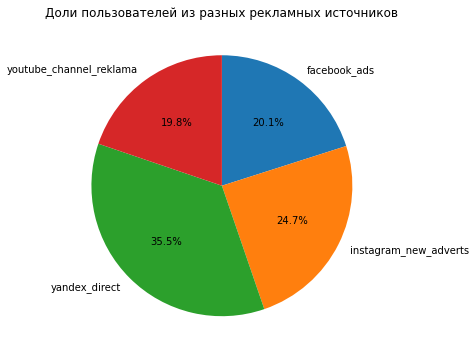

In [45]:
# оценим доли игроков по рекламным источникам
players = game_actions.groupby('source')['user_id'].nunique().reset_index()
players.rename(columns={'user_id':'n_user'},inplace=True)
display(players.head())

fig, ax = plt.subplots(figsize=(18, 6))

plt.title("Доли пользователей из разных рекламных источников")                                                
plt.pie(players['n_user'],                                             
            labels=players['source'],
            startangle=90, 
            autopct='%1.1f%%',
            counterclock=False)
plt.show()

#### Вывод

Как видим, игроки из рекламы Яндекс составляют 35.5% от общего количества, что заметно больше остальных Instagram(24.7%), Facebook (20.1%), YouTube (19.8%).

### Доля закончивших первый уровень

In [46]:
# срез по закончившим первый уровень 
finished_stage = game_actions.query('event == "finished_stage_1"')
finished_stage

,event_datetime,event,building_type,user_id,source,day
6659,2020-05-04 19:47:29,finished_stage_1,no_bilding,ced7b368-818f-48f6-9461-2346de0892c5,instagram_new_adverts,2020-05-04
13134,2020-05-05 13:22:09,finished_stage_1,no_bilding,7ef7fc89-2779-46ea-b328-9e5035b83af5,facebook_ads,2020-05-05
15274,2020-05-05 18:54:37,finished_stage_1,no_bilding,70db22b3-c2f4-43bc-94ea-51c8d2904a29,youtube_channel_reklama,2020-05-05
16284,2020-05-05 21:27:29,finished_stage_1,no_bilding,903fc9ef-ba97-4b12-9d5c-ac8d602fbd8b,youtube_channel_reklama,2020-05-05
19650,2020-05-06 06:02:22,finished_stage_1,no_bilding,58e077ba-feb1-4556-a5a0-d96bd04efa39,facebook_ads,2020-05-06
...,...,...,...,...,...,...
135631,2020-06-04 15:50:38,finished_stage_1,no_bilding,22cce310-fe10-41a2-941b-9c3d63327fea,yandex_direct,2020-06-04
135632,2020-06-04 17:56:14,finished_stage_1,no_bilding,d477dde8-7c22-4f23-9c4f-4ec31a1aa4c8,facebook_ads,2020-06-04
135635,2020-06-05 02:25:12,finished_stage_1,no_bilding,515c1952-99aa-4bca-a7ea-d0449eb5385a,yandex_direct,2020-06-05
135637,2020-06-05 12:12:27,finished_stage_1,no_bilding,32572adb-900f-4b5d-a453-1eb1e6d88d8b,facebook_ads,2020-06-05


In [47]:
# список и количество игроков завершивших первый уровень
finished_users = finished_stage['user_id'].unique().tolist()
n_finishers = len(finished_users)

print('За период с {} по {} закончили первый уровень {} уникальных игроков'
      .format(finished_stage['event_datetime'].min(),
              finished_stage['event_datetime'].max(),
              n_finishers ))

За период с 2020-05-04 19:47:29 по 2020-06-05 12:32:49 закончили первый уровень 5817 уникальных игроков


In [48]:
# определим долю закончивших игру
print('Закончили первый уровень {:.2%} игроков'.format(n_finishers/n_users))

Закончили первый уровень 42.85% игроков


In [49]:
# игроки закончившие уровень постройкой проекта
finished_by_project = game_actions.query('user_id in @finished_users & event == "project"')['user_id'].tolist()
n_finished_by_project = len(finished_by_project)

# игроки закончившие уровень победой над врагом
finished_by_victory = set(finished_users) - set(finished_by_project)
n_finished_by_victory = len(finished_by_victory)

print('1й уровень звершили {} игроков.\
      \n\nЗавершившие первый уровень игроки распределились следующим образом: \
      \n\n    реализовали проект - разработали орбитальную группировка спутников {:d} ({:.2%}) \
      \n    победили в бою - одержали победу над первым врагом {:d} ({:.2%})'.
      format(n_finishers,
             n_finished_by_project, n_finished_by_project/n_finishers,
             n_finished_by_victory,n_finished_by_victory/n_finishers)
      )

1й уровень звершили 5817 игроков.      

Завершившие первый уровень игроки распределились следующим образом:       

    реализовали проект - разработали орбитальную группировка спутников 1866 (32.08%)       
    победили в бою - одержали победу над первым врагом 3951 (67.92%)


In [50]:
# дополним основной датасет информацией о прохождении уровня игроком
# для этого применим метод apply()

# создадим функцию определяющую стадию прохождения уровня
def stage_finished(row):
    if row['user_id'] in finished_by_project:
        output = 'реализован проект'
    elif row['user_id'] in finished_by_victory:
        output = 'побежден враг'
    else:
        output = 'уровень не завершен'
    return output

# создадим столбец с результатами игрока 
game_actions['finished_stage'] = game_actions.apply(stage_finished, axis=1)
    
# смотрим датафрейм
game_actions.info()
game_actions.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 135639 entries, 0 to 135638
Data columns (total 7 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   event_datetime  135639 non-null  datetime64[ns]
 1   event           135639 non-null  object        
 2   building_type   135639 non-null  object        
 3   user_id         135639 non-null  object        
 4   source          135639 non-null  object        
 5   day             135639 non-null  object        
 6   finished_stage  135639 non-null  object        
dtypes: datetime64[ns](1), object(6)
memory usage: 8.3+ MB


,event_datetime,event,building_type,user_id,source,day,finished_stage
0,2020-05-04 00:00:01,building,assembly_shop,55e92310-cb8e-4754-b622-597e124b03de,youtube_channel_reklama,2020-05-04,уровень не завершен
1,2020-05-04 00:00:03,building,assembly_shop,c07b1c10-f477-44dc-81dc-ec82254b1347,facebook_ads,2020-05-04,реализован проект
2,2020-05-04 00:00:16,building,assembly_shop,6edd42cc-e753-4ff6-a947-2107cd560710,instagram_new_adverts,2020-05-04,побежден враг
3,2020-05-04 00:00:16,building,assembly_shop,92c69003-d60a-444a-827f-8cc51bf6bf4c,facebook_ads,2020-05-04,уровень не завершен
4,2020-05-04 00:00:35,building,assembly_shop,cdc6bb92-0ccb-4490-9866-ef142f09139d,yandex_direct,2020-05-04,побежден враг


#### Вывод

1й уровень звершили 5817 игроков, что составляет 42.85% от общего количества игроков, вступивших в игру с 4 по 10 мая включительно      

Завершившие первый уровень игроки распределились следующим образом:       

    реализовали проект - разработали орбитальную группировка спутников 1866 (32.08%)       
    победили в бою - одержали победу над первым врагом 3951 (67.92%)

### Количество событий на одного игрока

In [51]:
# определим количество событий на одного игрока за весь период
n_events_per_player = game_actions.groupby(['finished_stage','source','user_id']
                                 ).agg({'event':'count'}).reset_index()
n_events_per_player.rename(columns={'event':'n_events'},inplace=True)


n_events_per_player.info()
display(n_events_per_player.head())
display(n_events_per_player['n_events'].describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13576 entries, 0 to 13575
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   finished_stage  13576 non-null  object
 1   source          13576 non-null  object
 2   user_id         13576 non-null  object
 3   n_events        13576 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 424.4+ KB


,finished_stage,source,user_id,n_events
0,побежден враг,facebook_ads,004074f8-251a-4776-922c-8348dca1a2f6,13
1,побежден враг,facebook_ads,00b45f70-fc28-4af4-9867-487e0a2906e7,10
2,побежден враг,facebook_ads,016a07ce-04c7-4f29-a383-9975b97cfb3c,6
3,побежден враг,facebook_ads,023981cd-dd80-4062-933a-0ef93902bd3d,12
4,побежден враг,facebook_ads,025df02a-6265-4900-8525-cefb1508a5e4,10


count    13576.000000
mean         9.991087
std          4.146133
min          1.000000
25%          6.000000
50%         10.000000
75%         13.000000
max         22.000000
Name: n_events, dtype: float64

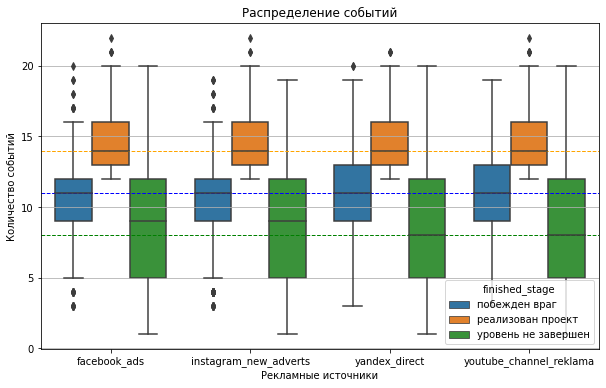

In [52]:
# построим график распределения количества событий на одного игрока
fig, ax = plt.subplots(figsize=(10, 6))
sns.boxplot(data=n_events_per_player,x='source',y='n_events', hue='finished_stage')

plt.title("Распределение событий") 
plt.xlabel("Рекламные источники")
plt.ylabel("Количество событий")
ax.yaxis.grid(True)

ax.axhline(y=11, color='blue', linestyle ='--', linewidth=1)
ax.axhline(y=14, color='orange', linestyle ='--', linewidth=1)
ax.axhline(y=8, color='green', linestyle ='--', linewidth=1)

plt.show()

In [53]:
# определим количество событий на одного игрока в день
n_events_per_player_dayly = game_actions.groupby(['finished_stage','source','day','user_id']
                                 ).agg({'event':'count'}).reset_index()
n_events_per_player_dayly.rename(columns={'event':'n_events'},inplace=True)

n_events_per_player_dayly.info()
display(n_events_per_player_dayly.head())
display(n_events_per_player_dayly['n_events'].describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 95201 entries, 0 to 95200
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   finished_stage  95201 non-null  object
 1   source          95201 non-null  object
 2   day             95201 non-null  object
 3   user_id         95201 non-null  object
 4   n_events        95201 non-null  int64 
dtypes: int64(1), object(4)
memory usage: 3.6+ MB


,finished_stage,source,day,user_id,n_events
0,побежден враг,facebook_ads,2020-05-04,004074f8-251a-4776-922c-8348dca1a2f6,2
1,побежден враг,facebook_ads,2020-05-04,03a632c2-67d3-460e-b733-9aacd887db1f,1
2,побежден враг,facebook_ads,2020-05-04,03d0d480-9103-46a3-83f5-22e48127541e,1
3,побежден враг,facebook_ads,2020-05-04,05b2ecdb-3807-42d3-8cef-804fd9f4a1ea,1
4,побежден враг,facebook_ads,2020-05-04,0694dc76-182d-4973-9d5c-94b094ba50a8,1


count    95201.000000
mean         1.424764
std          0.694164
min          1.000000
25%          1.000000
50%          1.000000
75%          2.000000
max          7.000000
Name: n_events, dtype: float64

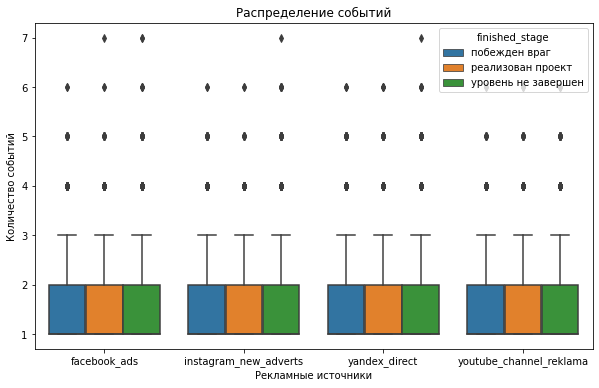

In [54]:
# построим график распределения количества событий на одного игрока в день
fig, ax = plt.subplots(figsize=(10, 6))
sns.boxplot(data=n_events_per_player_dayly,x='source',y='n_events',hue='finished_stage')

plt.title("Распределение событий") 
plt.xlabel("Рекламные источники")
plt.ylabel("Количество событий")
plt.show()

#### Вывод

Как следует из графиков на каждого игрока 1 уровня приходится в среднем 10 событий (разброс от 1 до 22, стандартное отклонение 4).

Медианное количество событий у завершивших уровень победой - 11, у завершивших реализацией проекта - 14.

В день на каждого игрока преимущественно приходится 1-2 события.

Поведение игроков, пришедших из разных рекламных источников не отличается.

### Доли игроков закончивших уровень по рекламным источникам

,source,n_user
0,facebook_ads,1150
1,instagram_new_adverts,1466
2,yandex_direct,2042
3,youtube_channel_reklama,1159


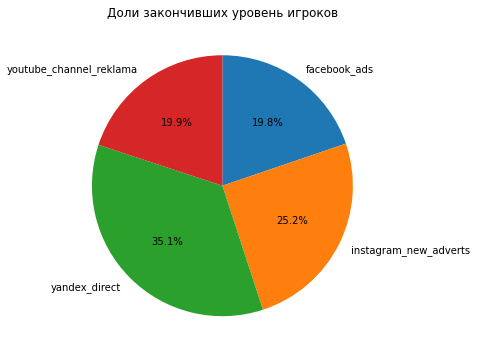

,source,n_user
0,facebook_ads,391
1,instagram_new_adverts,476
2,yandex_direct,620
3,youtube_channel_reklama,379


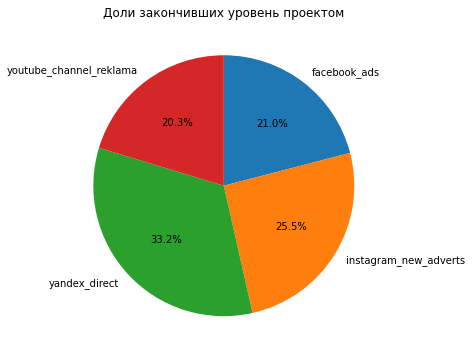

,source,n_user
0,facebook_ads,759
1,instagram_new_adverts,990
2,yandex_direct,1422
3,youtube_channel_reklama,780


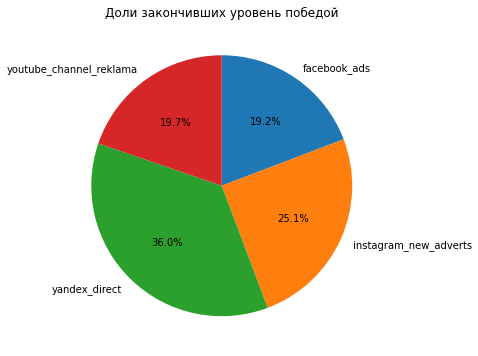

In [55]:
# оценим доли закончивших уровень игроков по рекламным источникам
part_list = {'Доли закончивших уровень игроков':'event == "finished_stage_1"',
             'Доли закончивших уровень проектом':'finished_stage == "реализован проект"',
             'Доли закончивших уровень победой':'finished_stage == "побежден враг"'}

for key in part_list:
    
    finished_players = game_actions.query(part_list[key]).groupby('source')['user_id'].nunique().reset_index()
    finished_players.rename(columns={'user_id':'n_user'},inplace=True)
    display(finished_players.head())

    fig, ax = plt.subplots(figsize=(18, 6))

    plt.title(key)                                                
    plt.pie(finished_players['n_user'],                                             
                labels=players['source'],
                startangle=90, 
                autopct='%1.1f%%',
                counterclock=False)
    
    plt.show()

#### Вывод

Как видим из диаграмм закончившие уровень игроки пришедшие из разных рекламных источников делятся примерно в тех же пропроциях, что и общее количество игроков.

Эти пропорции сохраняются и при различии способов завершения уровня - проектом или победой.

То есть заметного отличия в поведении пользователей пришедших из разных рекламных источников выделить пока не удается.

### Количество событий у игроков закончивших уровень

In [56]:
# получим срез датафрейма со всеми событиями пользователей, которые закончили первый уровень
stage_finishers = game_actions.query('finished_stage == "реализован проект" | finished_stage == "побежден враг"'
                                    ).sort_values(by=['user_id','event_datetime'])

stage_finishers.head()

,event_datetime,event,building_type,user_id,source,day,finished_stage
16131,2020-05-05 21:02:05,building,assembly_shop,001d39dc-366c-4021-9604-6a3b9ff01e25,instagram_new_adverts,2020-05-05,побежден враг
21619,2020-05-06 10:52:38,building,assembly_shop,001d39dc-366c-4021-9604-6a3b9ff01e25,instagram_new_adverts,2020-05-06,побежден враг
24136,2020-05-06 16:54:55,building,assembly_shop,001d39dc-366c-4021-9604-6a3b9ff01e25,instagram_new_adverts,2020-05-06,побежден враг
33911,2020-05-07 14:58:27,building,spaceport,001d39dc-366c-4021-9604-6a3b9ff01e25,instagram_new_adverts,2020-05-07,побежден враг
37727,2020-05-07 23:26:08,building,spaceport,001d39dc-366c-4021-9604-6a3b9ff01e25,instagram_new_adverts,2020-05-07,побежден враг


In [57]:
# группируем игроков по user_id, рекламному источнику и завершенности уровня, затем считаем количество событий
n_events_per_finisher = game_actions.groupby(['user_id','source','finished_stage']
                                 ).agg({'event':'count'}).reset_index()
n_events_per_finisher.rename(columns={'event':'n_events'},inplace=True)


n_events_per_finisher.info()
display(n_events_per_finisher.head())
display(n_events_per_finisher['n_events'].describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13576 entries, 0 to 13575
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   user_id         13576 non-null  object
 1   source          13576 non-null  object
 2   finished_stage  13576 non-null  object
 3   n_events        13576 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 424.4+ KB


,user_id,source,finished_stage,n_events
0,0001f83c-c6ac-4621-b7f0-8a28b283ac30,facebook_ads,уровень не завершен,13
1,00151b4f-ba38-44a8-a650-d7cf130a0105,yandex_direct,уровень не завершен,9
2,001aaea6-3d14-43f1-8ca8-7f48820f17aa,youtube_channel_reklama,уровень не завершен,4
3,001d39dc-366c-4021-9604-6a3b9ff01e25,instagram_new_adverts,побежден враг,9
4,002f508f-67b6-479f-814b-b05f00d4e995,facebook_ads,уровень не завершен,12


count    13576.000000
mean         9.991087
std          4.146133
min          1.000000
25%          6.000000
50%         10.000000
75%         13.000000
max         22.000000
Name: n_events, dtype: float64

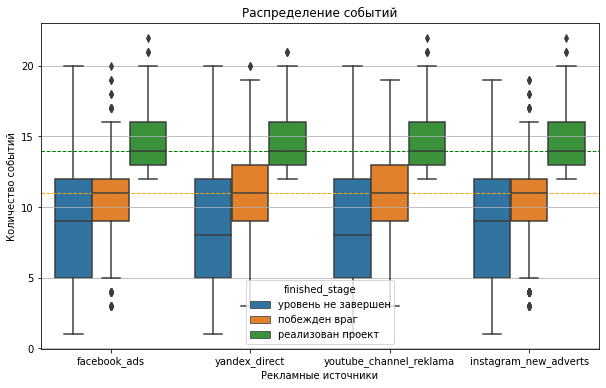

In [58]:
# построим график распределения событий по способу завершения уровня с разделением по рекламным источникам
fig, ax = plt.subplots(figsize=(10, 6))
sns.boxplot(data=n_events_per_finisher,x='source',y='n_events',hue='finished_stage')

plt.title("Распределение событий") 
plt.xlabel("Рекламные источники")
plt.ylabel("Количество событий")
ax.yaxis.grid(True)

ax.axhline(y=11, color='orange', linestyle ='--', linewidth=1)
ax.axhline(y=14, color='green', linestyle ='--', linewidth=1)

plt.show()

#### Вывод

Наиболее характерное количество событий у завершивших уровень победой над врагом - 11, а у завершивших проект - 14.

медианное значение у игроков не завершивших уровень - 8.

Игроки из разных рекламных источников завершают уровень с равным количеством событий, отличий не наблюдается.


### Завершение уровня по датам

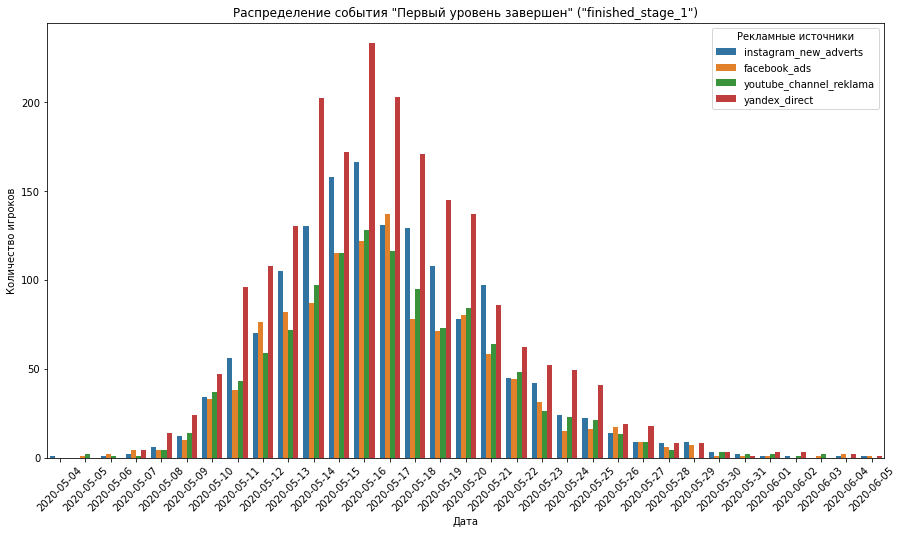

In [59]:
# как распределились события "finished_stage_1" по датам
finish_dates = finished_stage.groupby(['day','source'])['user_id'].count().reset_index()

finish_dates.columns = ['day','source','n_finishes']
finish_dates

# построим график распределения завершения уровня по датам
fig, ax = plt.subplots(figsize=(15, 8))

sns.barplot(data=finish_dates, x='day', y='n_finishes', hue='source')

plt.title('Распределение события "Первый уровень завершен" ("finished_stage_1")') 
plt.xlabel("Дата") 
plt.xticks(rotation=45)
plt.ylabel("Количество игроков")
plt.legend(title='Рекламные источники',loc="upper right" )

plt.show()

#### Вывод

Как видим, наибольшее количество завершения первого уровня  16-17 мая. Наблюдается также небольшой "всплеск" 20-21 мая.

События по всем источникам распределились близко к нормальному. 


### Количество строений на одного игрока

Определим, сколько строений у закончивших уровень, в т.ч. в разрезе типа завершения уровня и рекламных источников

In [60]:
# отсортируем события 
game_actions = game_actions.sort_values(by=['finished_stage','user_id','event_datetime','building_type'])
game_actions.head()

,event_datetime,event,building_type,user_id,source,day,finished_stage
16131,2020-05-05 21:02:05,building,assembly_shop,001d39dc-366c-4021-9604-6a3b9ff01e25,instagram_new_adverts,2020-05-05,побежден враг
21619,2020-05-06 10:52:38,building,assembly_shop,001d39dc-366c-4021-9604-6a3b9ff01e25,instagram_new_adverts,2020-05-06,побежден враг
24136,2020-05-06 16:54:55,building,assembly_shop,001d39dc-366c-4021-9604-6a3b9ff01e25,instagram_new_adverts,2020-05-06,побежден враг
33911,2020-05-07 14:58:27,building,spaceport,001d39dc-366c-4021-9604-6a3b9ff01e25,instagram_new_adverts,2020-05-07,побежден враг
37727,2020-05-07 23:26:08,building,spaceport,001d39dc-366c-4021-9604-6a3b9ff01e25,instagram_new_adverts,2020-05-07,побежден враг


In [61]:
# подсчитаем количество каждого события у игроков с учетом состояния завершенн уровня и id пользователя
buildings = game_actions.groupby(['finished_stage','source','user_id']
                                               ).apply(lambda group_series:
                                                       group_series['building_type'].value_counts()
                                                      ).reset_index()

buildings.columns = ['finished_stage','source','user_id','building_type','n_buildings']

buildings.head()

,finished_stage,source,user_id,building_type,n_buildings
0,побежден враг,facebook_ads,004074f8-251a-4776-922c-8348dca1a2f6,assembly_shop,6
1,побежден враг,facebook_ads,004074f8-251a-4776-922c-8348dca1a2f6,spaceport,4
2,побежден враг,facebook_ads,004074f8-251a-4776-922c-8348dca1a2f6,research_center,2
3,побежден враг,facebook_ads,004074f8-251a-4776-922c-8348dca1a2f6,no_bilding,1
4,побежден враг,facebook_ads,00b45f70-fc28-4af4-9867-487e0a2906e7,assembly_shop,5


In [62]:
# удалим строки с no_bilding
buildings = buildings.query('building_type != "no_bilding"')
buildings.head()

,finished_stage,source,user_id,building_type,n_buildings
0,побежден враг,facebook_ads,004074f8-251a-4776-922c-8348dca1a2f6,assembly_shop,6
1,побежден враг,facebook_ads,004074f8-251a-4776-922c-8348dca1a2f6,spaceport,4
2,побежден враг,facebook_ads,004074f8-251a-4776-922c-8348dca1a2f6,research_center,2
4,побежден враг,facebook_ads,00b45f70-fc28-4af4-9867-487e0a2906e7,assembly_shop,5
5,побежден враг,facebook_ads,00b45f70-fc28-4af4-9867-487e0a2906e7,spaceport,3


In [63]:
# сгруппируем и посчитаем постройки
buildings_by_stage = buildings.groupby(['finished_stage','source','building_type']
                                      ).agg({'n_buildings':'sum','user_id':'nunique'}).reset_index()

buildings_by_stage['n_build_mean'] = (buildings_by_stage['n_buildings'] / buildings_by_stage['user_id']
                                     ).round().astype('int')

buildings_by_stage.head()

,finished_stage,source,building_type,n_buildings,user_id,n_build_mean
0,побежден враг,facebook_ads,assembly_shop,3172,759,4
1,побежден враг,facebook_ads,research_center,747,460,2
2,побежден враг,facebook_ads,spaceport,3238,748,4
3,побежден враг,instagram_new_adverts,assembly_shop,4030,990,4
4,побежден враг,instagram_new_adverts,research_center,929,576,2


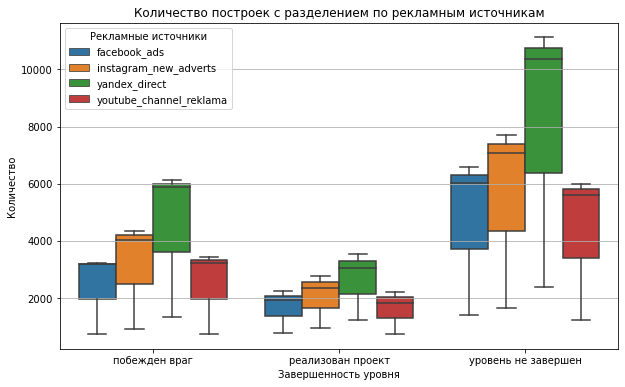

In [64]:
# построим график количества построек разрезе завершенности уровня и рекламных источников
fig, ax = plt.subplots(figsize=(10, 6))

ax.yaxis.grid(True)
sns.boxplot(data=buildings_by_stage, x='finished_stage', y='n_buildings',hue='source') 
plt.title("Количество построек с разделением по рекламным источникам") 
plt.ylabel("Количество") 
plt.xlabel("Завершенность уровня")

plt.legend(title='Рекламные источники',loc="best" )

plt.show()

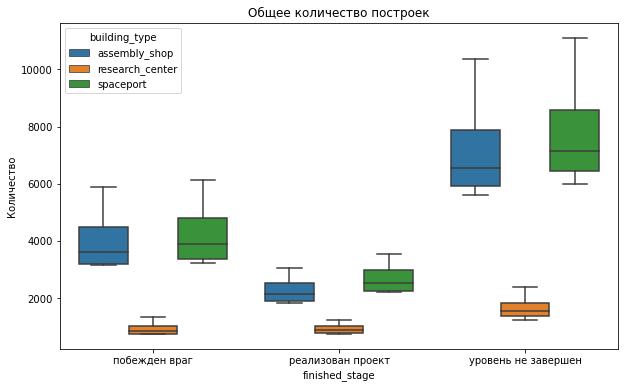

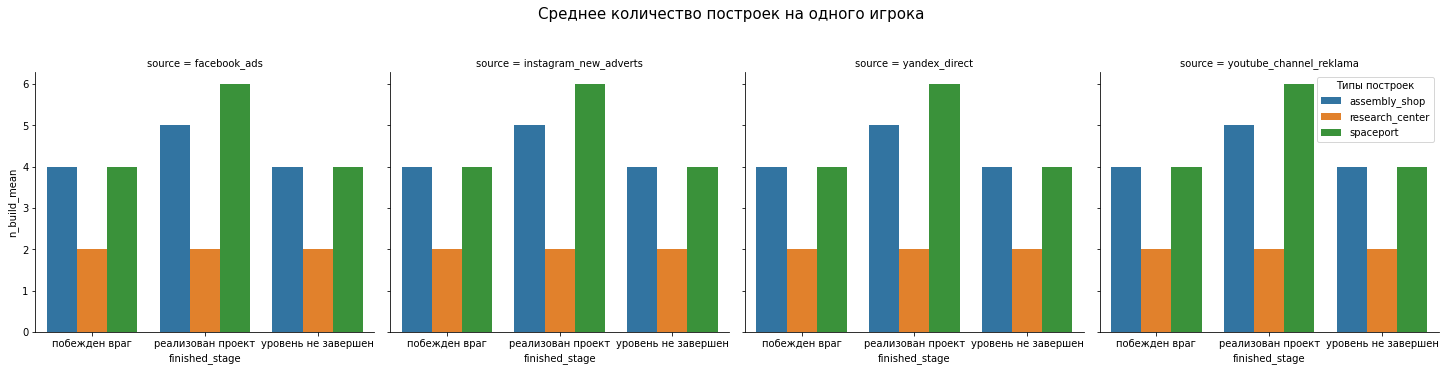

In [65]:
# построим график количества построек разрезе завершенности уровня и типов построек
fig, ax = plt.subplots(figsize=(10, 6))
sns.boxplot(data=buildings_by_stage, x='finished_stage', y='n_buildings',hue='building_type')
plt.title("Общее количество построек") 
plt.ylabel("Количество") 

plt.show()

# построим график среднего количества построек каждого вида на одного игрока
# по завершенности уровня и рекламным источникам
g=sns.catplot(data=buildings_by_stage, 
            x='finished_stage', 
            y='n_build_mean',
            hue='building_type',
            col='source',
            kind="bar",
            legend=False)


g.fig.subplots_adjust(top=0.8)
g.fig.suptitle('Среднее количество построек на одного игрока',fontsize=15)
plt.legend(title='Типы построек',loc="best" )

plt.show()

#### Вывод

Как видим из графиков - для завершения уровня победой над врагом игрокам требуется меньшее количество зданий.

То есть большее количество строений у тех, кто завершил уровень реализацией проекта.

Существенных различий в поведении игроков (независимо от завершения уровня) пришедших из разных рекламных источников по-прежнему не наблюдается.

### Продолжительность игры на первом уровне

Рассчитаем продолжительность игры для каждого игрока

In [66]:
# определим для каждого пользователя дату первого события 
first_event_date = game_actions.groupby(['user_id'])['event_datetime'].min()
display(first_event_date.head())

# определим для каждого пользователя дату последнего события
last_event_date = game_actions.groupby(['user_id'])['event_datetime'].max()
display(last_event_date.head())

# переименуем столбцы с получеными значениями
first_event_date.name = 'first_activity_date'
last_event_date.name = 'last_activity_date'

# объединим полученный столбец с информацией о визитах по полю - идентификатору пользователя
game_actions = game_actions.join(first_event_date,on='user_id')
game_actions = game_actions.join(last_event_date,on='user_id')
game_actions.head()

user_id
0001f83c-c6ac-4621-b7f0-8a28b283ac30   2020-05-06 01:07:37
00151b4f-ba38-44a8-a650-d7cf130a0105   2020-05-06 03:09:12
001aaea6-3d14-43f1-8ca8-7f48820f17aa   2020-05-05 18:08:52
001d39dc-366c-4021-9604-6a3b9ff01e25   2020-05-05 21:02:05
002f508f-67b6-479f-814b-b05f00d4e995   2020-05-05 13:49:58
Name: event_datetime, dtype: datetime64[ns]

user_id
0001f83c-c6ac-4621-b7f0-8a28b283ac30   2020-05-20 11:26:06
00151b4f-ba38-44a8-a650-d7cf130a0105   2020-05-18 10:46:52
001aaea6-3d14-43f1-8ca8-7f48820f17aa   2020-05-14 09:21:27
001d39dc-366c-4021-9604-6a3b9ff01e25   2020-05-12 07:40:47
002f508f-67b6-479f-814b-b05f00d4e995   2020-05-22 02:46:45
Name: event_datetime, dtype: datetime64[ns]

,event_datetime,event,building_type,user_id,source,day,finished_stage,first_activity_date,last_activity_date
16131,2020-05-05 21:02:05,building,assembly_shop,001d39dc-366c-4021-9604-6a3b9ff01e25,instagram_new_adverts,2020-05-05,побежден враг,2020-05-05 21:02:05,2020-05-12 07:40:47
21619,2020-05-06 10:52:38,building,assembly_shop,001d39dc-366c-4021-9604-6a3b9ff01e25,instagram_new_adverts,2020-05-06,побежден враг,2020-05-05 21:02:05,2020-05-12 07:40:47
24136,2020-05-06 16:54:55,building,assembly_shop,001d39dc-366c-4021-9604-6a3b9ff01e25,instagram_new_adverts,2020-05-06,побежден враг,2020-05-05 21:02:05,2020-05-12 07:40:47
33911,2020-05-07 14:58:27,building,spaceport,001d39dc-366c-4021-9604-6a3b9ff01e25,instagram_new_adverts,2020-05-07,побежден враг,2020-05-05 21:02:05,2020-05-12 07:40:47
37727,2020-05-07 23:26:08,building,spaceport,001d39dc-366c-4021-9604-6a3b9ff01e25,instagram_new_adverts,2020-05-07,побежден враг,2020-05-05 21:02:05,2020-05-12 07:40:47


In [67]:
# расчитаем для каждого игрока продолжительность между первым и последним событиями в днях
game_actions['user_lifetime'] = round((game_actions['last_activity_date'] 
                                       - game_actions['first_activity_date']) 
                                      / np.timedelta64(1, 'D'),0).astype('int')
# 
game_act_lifetime = game_actions.groupby(['user_id']).first().reset_index()

game_act_lifetime.info()
game_act_lifetime.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13576 entries, 0 to 13575
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   user_id              13576 non-null  object        
 1   event_datetime       13576 non-null  datetime64[ns]
 2   event                13576 non-null  object        
 3   building_type        13576 non-null  object        
 4   source               13576 non-null  object        
 5   day                  13576 non-null  object        
 6   finished_stage       13576 non-null  object        
 7   first_activity_date  13576 non-null  datetime64[ns]
 8   last_activity_date   13576 non-null  datetime64[ns]
 9   user_lifetime        13576 non-null  int32         
dtypes: datetime64[ns](3), int32(1), object(6)
memory usage: 1007.7+ KB


,user_id,event_datetime,event,building_type,source,day,finished_stage,first_activity_date,last_activity_date,user_lifetime
0,0001f83c-c6ac-4621-b7f0-8a28b283ac30,2020-05-06 01:07:37,building,assembly_shop,facebook_ads,2020-05-06,уровень не завершен,2020-05-06 01:07:37,2020-05-20 11:26:06,14
1,00151b4f-ba38-44a8-a650-d7cf130a0105,2020-05-06 03:09:12,building,assembly_shop,yandex_direct,2020-05-06,уровень не завершен,2020-05-06 03:09:12,2020-05-18 10:46:52,12
2,001aaea6-3d14-43f1-8ca8-7f48820f17aa,2020-05-05 18:08:52,building,assembly_shop,youtube_channel_reklama,2020-05-05,уровень не завершен,2020-05-05 18:08:52,2020-05-14 09:21:27,9
3,001d39dc-366c-4021-9604-6a3b9ff01e25,2020-05-05 21:02:05,building,assembly_shop,instagram_new_adverts,2020-05-05,побежден враг,2020-05-05 21:02:05,2020-05-12 07:40:47,6
4,002f508f-67b6-479f-814b-b05f00d4e995,2020-05-05 13:49:58,building,assembly_shop,facebook_ads,2020-05-05,уровень не завершен,2020-05-05 13:49:58,2020-05-22 02:46:45,17


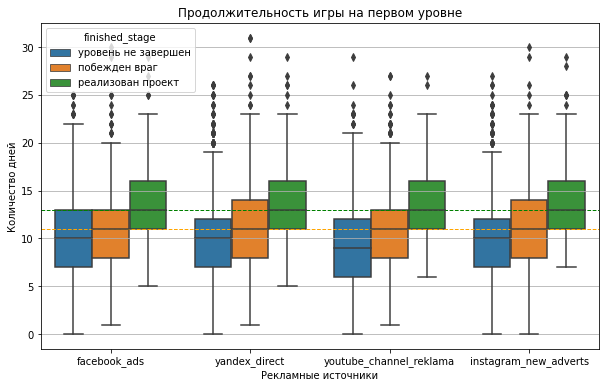

In [68]:
# определим количество событий на одного игрока, завершившего уровень
fig, ax = plt.subplots(figsize=(10, 6))
sns.boxplot(data=game_act_lifetime,x='source',y='user_lifetime', hue='finished_stage')

plt.title("Продолжительность игры на первом уровне") 
plt.xlabel("Рекламные источники")
plt.ylabel("Количество дней")
ax.yaxis.grid(True)
ax.axhline(y=11, color='orange', linestyle ='--', linewidth=1)
ax.axhline(y=13, color='green', linestyle ='--', linewidth=1)
plt.show()

#### Вывод

На прохождение первого уровня победой над врагом в рассматриваемой когорте пользователей игрокам понадобилось в среднем 11 дней. 

Для завершения уровня реализацией проекта - в среднем 13 дней.

Существенных различий в продолжительности игры (независимо от завершения уровня) у игроков, пришедших из разных рекламных источников также не наблюдается.

### Коэффициент удержания пользователей (Retention Rate)

Рассчитаем коэффициент удержания пользователей применяя когортный анализ.

Разделим пользователей на когорты по дате первого события в игре. 

In [69]:
game_actions.info()
game_actions.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 135639 entries, 16131 to 85880
Data columns (total 10 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   event_datetime       135639 non-null  datetime64[ns]
 1   event                135639 non-null  object        
 2   building_type        135639 non-null  object        
 3   user_id              135639 non-null  object        
 4   source               135639 non-null  object        
 5   day                  135639 non-null  object        
 6   finished_stage       135639 non-null  object        
 7   first_activity_date  135639 non-null  datetime64[ns]
 8   last_activity_date   135639 non-null  datetime64[ns]
 9   user_lifetime        135639 non-null  int32         
dtypes: datetime64[ns](3), int32(1), object(6)
memory usage: 10.9+ MB


,event_datetime,event,building_type,user_id,source,day,finished_stage,first_activity_date,last_activity_date,user_lifetime
16131,2020-05-05 21:02:05,building,assembly_shop,001d39dc-366c-4021-9604-6a3b9ff01e25,instagram_new_adverts,2020-05-05,побежден враг,2020-05-05 21:02:05,2020-05-12 07:40:47,6
21619,2020-05-06 10:52:38,building,assembly_shop,001d39dc-366c-4021-9604-6a3b9ff01e25,instagram_new_adverts,2020-05-06,побежден враг,2020-05-05 21:02:05,2020-05-12 07:40:47,6
24136,2020-05-06 16:54:55,building,assembly_shop,001d39dc-366c-4021-9604-6a3b9ff01e25,instagram_new_adverts,2020-05-06,побежден враг,2020-05-05 21:02:05,2020-05-12 07:40:47,6
33911,2020-05-07 14:58:27,building,spaceport,001d39dc-366c-4021-9604-6a3b9ff01e25,instagram_new_adverts,2020-05-07,побежден враг,2020-05-05 21:02:05,2020-05-12 07:40:47,6
37727,2020-05-07 23:26:08,building,spaceport,001d39dc-366c-4021-9604-6a3b9ff01e25,instagram_new_adverts,2020-05-07,побежден враг,2020-05-05 21:02:05,2020-05-12 07:40:47,6


In [70]:
# добавим день первого события
game_actions['first_event_day'] = game_actions['first_activity_date'].astype('datetime64[D]')
# преобразуем день события к формату даты
game_actions['day'] = pd.to_datetime(game_actions['day'])

# посчитаем разницу в днях между текущим обращением и первым
game_actions['cohort_lifetime'] = (game_actions['day'] - game_actions['first_event_day']) / np.timedelta64(1, 'D')

# и округлим до целых значений
game_actions['cohort_lifetime'] = game_actions['cohort_lifetime'].round().astype('int')


In [71]:
# создадим таблицу `cohorts` посчитав количество уникальных пользователей в каждый день продолжительности жизни когорты
cohorts = game_actions.groupby(['source','first_event_day','cohort_lifetime']).agg({'user_id':'nunique'}).reset_index() 
# переименуем столбец с количеством пользователей
cohorts = cohorts.rename(columns={'user_id':'n_users'}) 
cohorts.head()

,source,first_event_day,cohort_lifetime,n_users
0,facebook_ads,2020-05-04,0,1184
1,facebook_ads,2020-05-04,1,634
2,facebook_ads,2020-05-04,2,652
3,facebook_ads,2020-05-04,3,703
4,facebook_ads,2020-05-04,4,717


In [72]:
# посчитаем начальное количество уникальных пользователей в каждой когорте
initial_users_count = cohorts[cohorts['cohort_lifetime'] == 0][['source','first_event_day', 'n_users']]
# переименуем столбец с первоначальным количеством пользователей в каждой когорте
initial_users_count = initial_users_count.rename(columns={'n_users':'cohort_users'}) 

initial_users_count.head()

,source,first_event_day,cohort_users
0,facebook_ads,2020-05-04,1184
28,facebook_ads,2020-05-05,694
55,facebook_ads,2020-05-06,345
78,facebook_ads,2020-05-07,224
108,facebook_ads,2020-05-08,139


In [73]:
# объединим таблицы cohorts и initial_users_count по признаку первого события
cohorts = cohorts.merge(initial_users_count,on=['source','first_event_day'])

# рассчитаем и добавим к таблице cohorts коэффициент удержания
cohorts['retention'] = cohorts['n_users']/cohorts['cohort_users']

cohorts

,source,first_event_day,cohort_lifetime,n_users,cohort_users,retention
0,facebook_ads,2020-05-04,0,1184,1184,1.000000
1,facebook_ads,2020-05-04,1,634,1184,0.535473
2,facebook_ads,2020-05-04,2,652,1184,0.550676
3,facebook_ads,2020-05-04,3,703,1184,0.593750
4,facebook_ads,2020-05-04,4,717,1184,0.605574
...,...,...,...,...,...,...
711,youtube_channel_reklama,2020-05-10,16,3,56,0.053571
712,youtube_channel_reklama,2020-05-10,17,1,56,0.017857
713,youtube_channel_reklama,2020-05-10,19,1,56,0.017857
714,youtube_channel_reklama,2020-05-10,20,2,56,0.035714


In [74]:
# построим сводную таблицу для просмотра Retention Rate
retention_pivot = cohorts.pivot_table(
            index=['source','first_event_day'],
            columns='cohort_lifetime',
            values='retention',
            aggfunc='sum',
)

retention_pivot.fillna(' ')

cohort_lifetime                           0         1         2         3   \
source                  first_event_day                                      
facebook_ads            2020-05-04       1.0  0.535473  0.550676  0.593750   
                        2020-05-05       1.0  0.564841  0.618156  0.615274   
                        2020-05-06       1.0  0.518841  0.539130  0.637681   
                        2020-05-07       1.0  0.508929  0.571429  0.629464   
                        2020-05-08       1.0  0.402878  0.561151  0.338129   
                        2020-05-09       1.0  0.500000  0.369048  0.333333   
                        2020-05-10       1.0  0.339286  0.392857  0.428571   
instagram_new_adverts   2020-05-04       1.0  0.511708  0.535813  0.581956   
                        2020-05-05       1.0  0.527638  0.540201  0.600503   
                        2020-05-06       1.0  0.544492  0.548729  0.605932   
                        2020-05-07       1.0  0.540741  0.525926  0.611111   
                        2020-05-08       1.0  0.508571  0.548571  0.342857   
                        2020-05-09       1.0  0.491071  0.339286  0.321429   
                        2020-05-10       1.0  0.214286  0.285714  0.300000   
yandex_direct           2020-05-04       1.0  0.521174  0.548604  0.575072   
                        2020-05-05       1.0  0.530629  0.570364  0.612583   
                        2020-05-06       1.0  0.503012  0.557229  0.593373   
                        2020-05-07       1.0  0.483544  0.529114  0.577215   
                        2020-05-08       1.0  0.506276  0.548117  0.376569   
                        2020-05-09       1.0  0.451389  0.340278  0.326389   
                        2020-05-10       1.0  0.280899  0.224719  0.303371   
youtube_channel_reklama 2020-05-04       1.0  0.489529  0.553229  0.583770   
                        2020-05-05       1.0  0.527903  0.535445  0.622926   
                        2020-05-06       1.0  0.519126  0.554645  0.595628   
                        2020-05-07       1.0  0.509091  0.609091  0.595455   
                        2020-05-08       1.0  0.488889  0.518519  0.333333   
                        2020-05-09       1.0  0.490000  0.230000  0.380000   
                        2020-05-10       1.0  0.178571  0.339286  0.303571   

cohort_lifetime                                4         5         6   \
source                  first_event_day                                 
facebook_ads            2020-05-04       0.605574  0.658784  0.711149   
                        2020-05-05       0.622478  0.678674  0.536023   
                        2020-05-06       0.666667  0.475362  0.472464   
                        2020-05-07       0.352679  0.370536  0.473214   
                        2020-05-08       0.381295  0.424460  0.417266   
                        2020-05-09       0.392857  0.416667  0.428571   
                        2020-05-10       0.303571  0.446429  0.321429   
instagram_new_adverts   2020-05-04       0.622590  0.643251  0.715565   
                        2020-05-05       0.645729  0.708543  0.445980   
                        2020-05-06       0.661017  0.385593  0.455508   
                        2020-05-07       0.392593  0.396296  0.485185   
                        2020-05-08       0.440000  0.394286  0.428571   
                        2020-05-09       0.446429  0.419643  0.526786   
                        2020-05-10       0.357143  0.428571  0.485714   
yandex_direct           2020-05-04       0.598653  0.631858  0.708373   
                        2020-05-05       0.643212  0.685430  0.473510   
                        2020-05-06       0.689759  0.469880  0.429217   
                        2020-05-07       0.389873  0.435443  0.453165   
                        2020-05-08       0.368201  0.401674  0.447699   
                        2020-05-09       0.375000  0.381944  0.333333   
                        2020-05-10       0.348315  0.

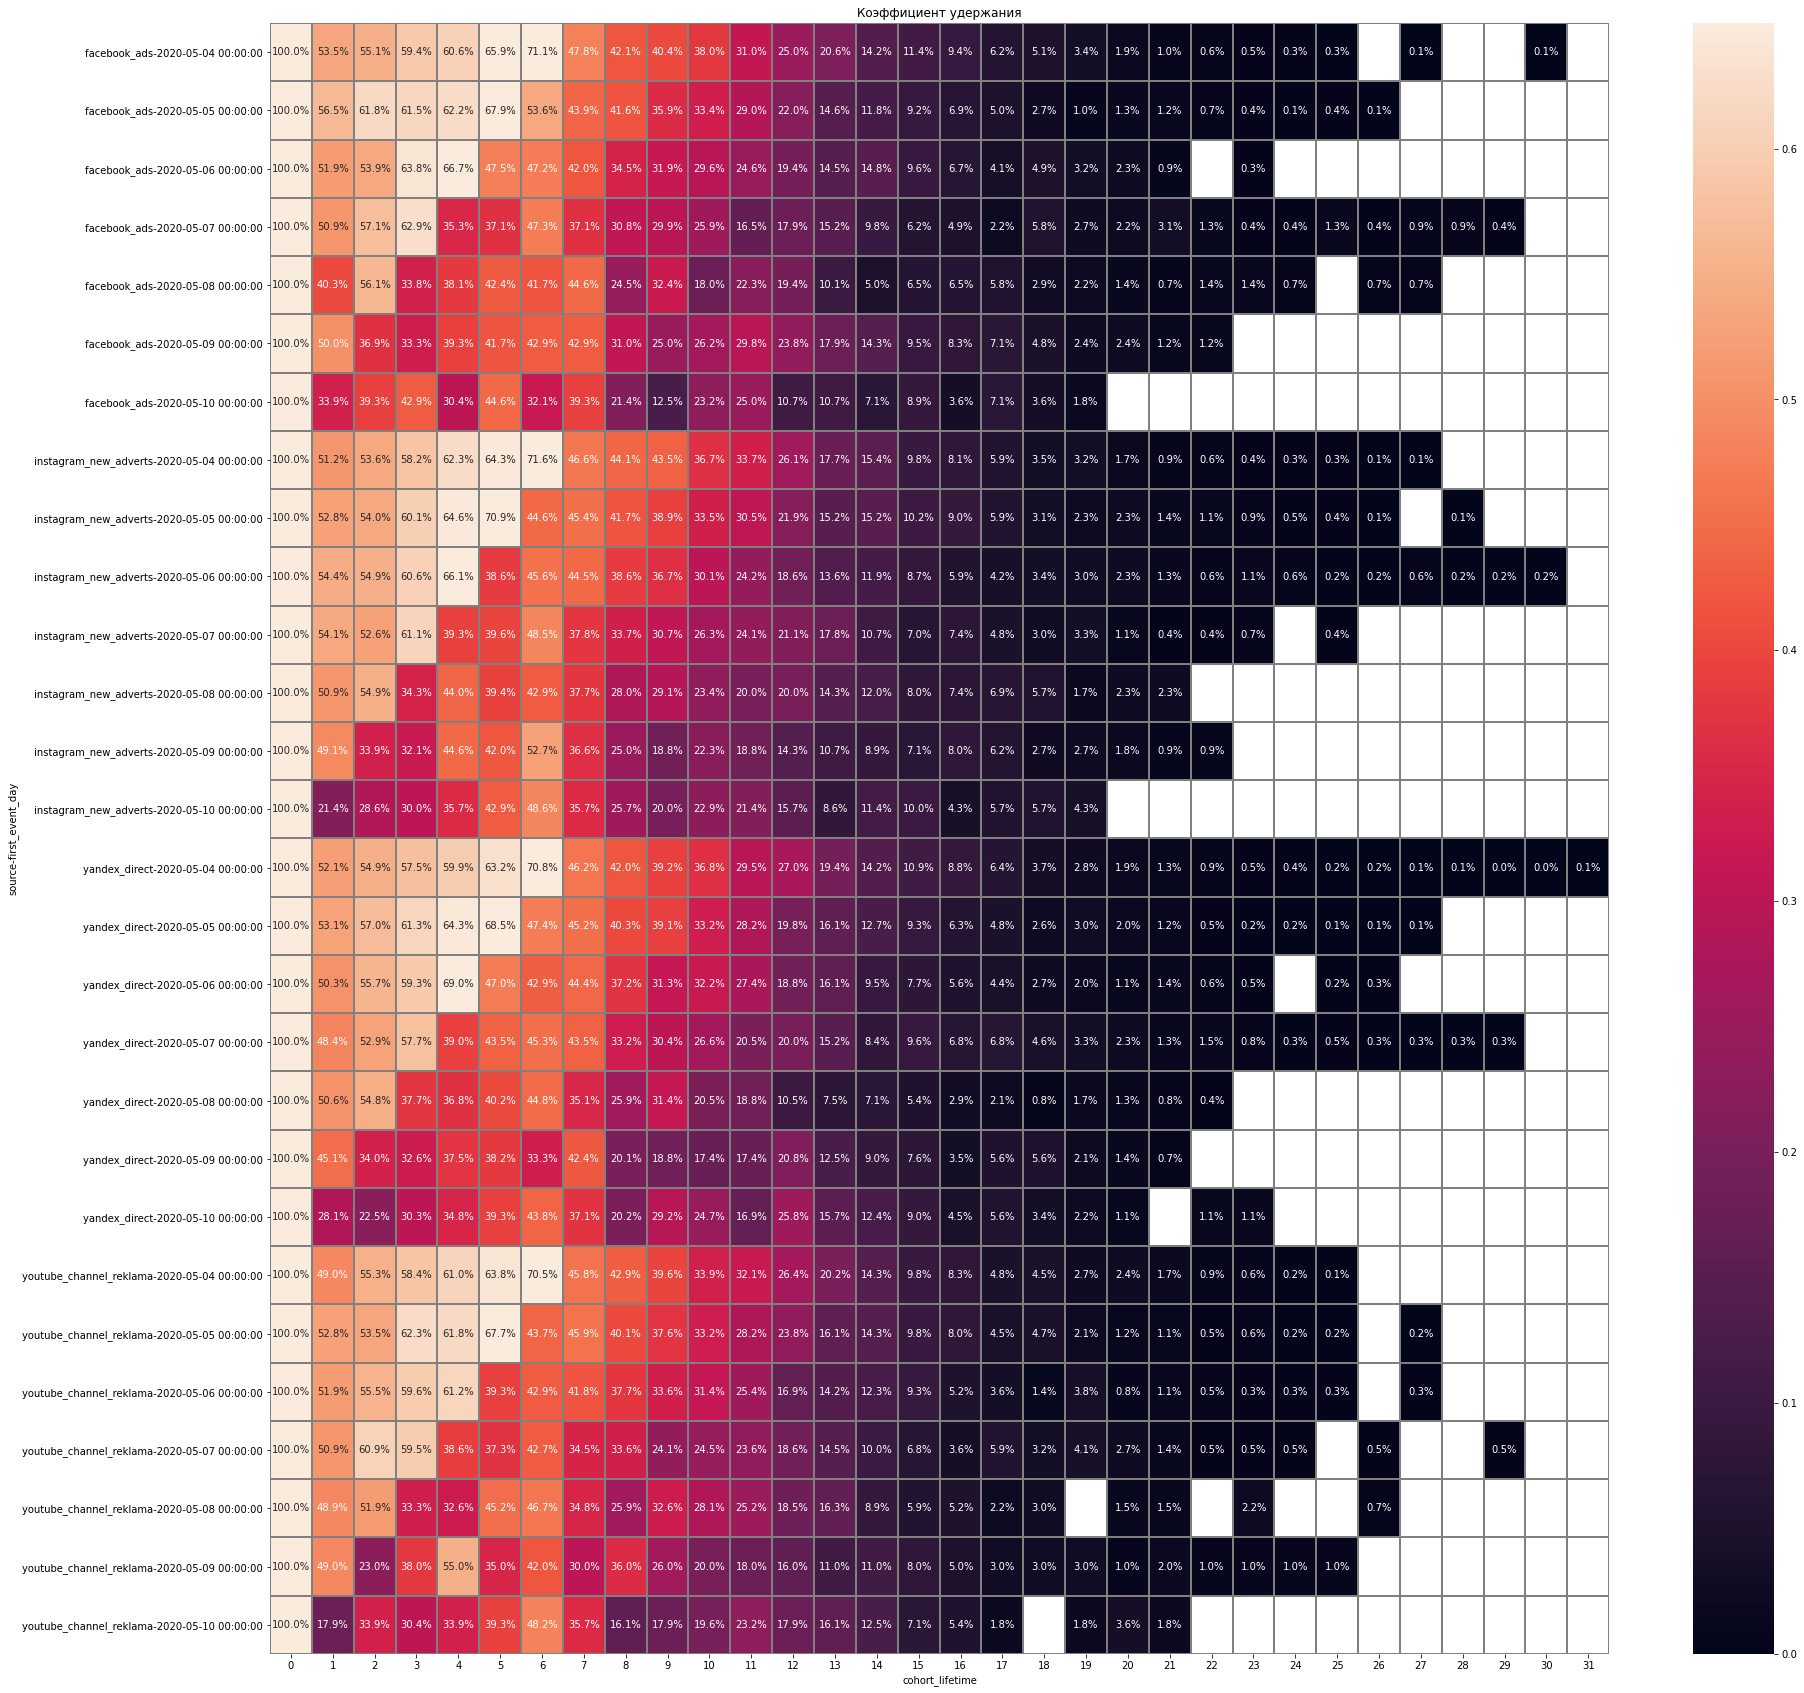

In [75]:
# для наглядности построим график "тепловую карту" для полученой таблицы
plt.figure(figsize=(30,30))
plt.title('Коэффициент удержания')

ax.set_xlabel('Продолжительность "жизни" когорт, дни')
ax.set_ylabel('Рекламный источник - когорта (день первой покупки')

sns.heatmap(retention_pivot, annot=True, fmt='.1%',
            vmin= 0, vmax=0.65, 
            linewidths=1, linecolor='gray') 
plt.show()

#### Вывод

Рассмотрев тепловую карту можно сделать вывод о том, что игроки после первого события проявляют заметно более высокую активность на 6-7 день, после 11-12 дня активность резко снижается.

Сравнивая эти результаты с продолжительностью игры до завершения уровня видим определенную взаимосвязь. С учетом в среднем двух событий в день и 11-13 событий от начала игры до завершения уровня, можно предположить что мименно после 6-7 дня игроки приближаются к завершению уровня и повышают активность. 

Далее  уровень завершается и информации по игроку в предоставленном датасете больше нет, что можно интерпретировать как отток. 

Суммируясь с естественным оттоком эта метрика дает резкий скачок вниз.

В разрезе рекламных источников отличий в поведении пользователей также не наблюдается.

## Проверка статистических гипотез

### Гипотеза о равенстве времени прохождения первого уровня разными способами

Проверим статистическию гипотезу: 

`Время завершения уровня различается в зависимости способа прохождения:
        - через реализацию проекта,
        - через победу над первым врагом.`
        
Сформулируем нулевую и альтернативную гипотезы. Т.к. нулевая гипотеза - это гипотеза о равенстве, то сформулируем ее следующим образом: 

H₀ = "Продолжительность игры до завершения уровня через реализацию проекта не отличается от продолжительности игры до победы над врагом",

тогда альтернативная гипотеза будет звучать:

H₁ = "Продолжительность игры до завершения уровня через реализацию проекта  отличается от продолжительности игры до победы над врагом"

    

Для тестирования применим метод scipy.stats.ttest_ind для сравнения средних двух генеральных совокупностей.

Подготовим данные для тестирования гипотез. Продолжительность игры будем рассчитывать в сутках. Уровень статистической значимости примем равным 0.05

Воспользуемся ранее полученным датафреймом `game_act_lifetime` и отберем данные по продолжительности игры по признаку завершения уровня.

In [76]:
game_act_lifetime.head()

,user_id,event_datetime,event,building_type,source,day,finished_stage,first_activity_date,last_activity_date,user_lifetime
0,0001f83c-c6ac-4621-b7f0-8a28b283ac30,2020-05-06 01:07:37,building,assembly_shop,facebook_ads,2020-05-06,уровень не завершен,2020-05-06 01:07:37,2020-05-20 11:26:06,14
1,00151b4f-ba38-44a8-a650-d7cf130a0105,2020-05-06 03:09:12,building,assembly_shop,yandex_direct,2020-05-06,уровень не завершен,2020-05-06 03:09:12,2020-05-18 10:46:52,12
2,001aaea6-3d14-43f1-8ca8-7f48820f17aa,2020-05-05 18:08:52,building,assembly_shop,youtube_channel_reklama,2020-05-05,уровень не завершен,2020-05-05 18:08:52,2020-05-14 09:21:27,9
3,001d39dc-366c-4021-9604-6a3b9ff01e25,2020-05-05 21:02:05,building,assembly_shop,instagram_new_adverts,2020-05-05,побежден враг,2020-05-05 21:02:05,2020-05-12 07:40:47,6
4,002f508f-67b6-479f-814b-b05f00d4e995,2020-05-05 13:49:58,building,assembly_shop,facebook_ads,2020-05-05,уровень не завершен,2020-05-05 13:49:58,2020-05-22 02:46:45,17


In [77]:
# выборка для завершивших уровень реализацией проекта
project_realized = game_act_lifetime.query('finished_stage == "реализован проект"')
project_realized_arr = project_realized ['user_lifetime'].to_list()

# выборка для завершивших уровень победой над врагом
enemy_defeated = game_act_lifetime.query('finished_stage == "побежден враг"')
enemy_defeated_arr = enemy_defeated ['user_lifetime'].to_list()

Проведем статистический тест и сделаем вывод.

In [78]:
alpha = 0.05  # критический уровень статистической значимости

results = st.ttest_ind(project_realized_arr, enemy_defeated_arr)

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу') 
    

p-значение: 9.631515322512218e-98
Отвергаем нулевую гипотезу


#### Вывод

Статистический тест подтвердил наличие различия во времени прохождения уровня при завершении разными способами, нулевая гипотеза отвергнута.

### Гипотеза о равенстве времени игры у игроков из разных рекламных источников

Проверим статистическую гипотезу:

`Время нахождения в игре у игроков пришедших через рекламу в  Facebook и Яндекс одинаково`.

Сформулируем нулевую и альтернативную гипотезы. Т.к. нулевая гипотеза - это гипотеза о равенстве, то сформулируем ее следующим образом:

H₀ = "Время нахождения в игре у игроков пришедших через рекламу в  Facebook и Яндекс одинаково",

тогда альтернативная гипотеза будет звучать:

H₁ = "Время нахождения в игре у игроков пришедших через рекламу в  Facebook и Яндекс различаются"

Подготовим данные для тестирования гипотез. Продолжительность игры будем рассчитывать в сутках.

Уровень статистической значимости примем равным 0.05

In [79]:
# выборка для игроков из Facebook
facebook_gamers = game_act_lifetime.query('source == "facebook_ads"')
facebook_gamers_arr = facebook_gamers ['user_lifetime'].to_list()

# выборка для игроков из Яндекс
yandex_gamers = game_act_lifetime.query('source == "yandex_direct"')
yandex_gamers_arr = yandex_gamers['user_lifetime'].to_list()

In [80]:
alpha = 0.05  # критический уровень статистической значимости

results = st.ttest_ind(facebook_gamers_arr, yandex_gamers_arr)

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу') 

p-значение: 0.2075813368170734
Не получилось отвергнуть нулевую гипотезу


#### Вывод

Статистический тест подтвердил сходство поведения (продолжительности игры) игроков, зашедших в игру из разных рекламных источников, отвергнуть нулевую гипотезу нет оснований.

## Выводы

Данные о событиях предоставлены примерно за один месяц - с полуночи 4 мая 2020 до полудня 5 июня 2020.

Данные о переходах пользователей с рекламных источников предоставлены за период с 03 мая по 09 мая 2020 года, что не полностью совпадает по датам с периодом данных о действиях игроков.

В игре замечены 13576 уникальных игроков.

Средняя стоимость привлечения одного игрока по проекту в целом составляет 0.56 у.е.

Средние значения САС по рекламе выше среднего по проекту вцелом в Facebook(+38%) и Instagram(+16%) , а САС Яндекса и YouTube ниже на 18% и 29% соответственно.

Игроки из рекламы Яндекс составляют 35.5% от общего количества, что заметно больше остальных: Instagram(24.7%), Facebook (20.1%), YouTube (19.8%).

1й уровень звершили 5817 игроков, что составляет 42.85% от общего количества игроков, вступивших в игру с 4 по 10 мая включительно

Завершившие первый уровень игроки распределились следующим образом:
- реализовали проект - разработали орбитальную группировка спутников 1866 (32.08%)       
- победили в бою - одержали победу над первым врагом 3951 (67.92%)

Медианное количество событий у завершивших уровень победой - 11, у завершивших реализацией проекта - 14. Количество зданий у игроков не завершивших уровень - 9-10.

В день на каждого игрока преимущественно приходится 1-2 события. Количество событий у игроков, пришедших из разных рекламных источников не отличается.

Игроки, завершившие уровень и пришедшие из разных рекламных источников делятся примерно в тех же пропроциях, что и общее количество игроков. Эти пропорции сохраняются и при различии способов завершения уровня - проектом или победой.

Для завершения уровня победой над врагом игрокам требуется меньшее количество зданий.
Большее количество строений у тех, кто завершил уровень реализацией проекта.
Существенных различий в поведении игроков (независимо от завершения уровня) пришедших из разных рекламных источников не наблюдается.

На прохождение первого уровня победой над врагом в рассматриваемой когорте пользователей игрокам понадобилось в среднем 11 дней.
Для завершения уровня реализацией проекта - в среднем 13 дней.
Существенных различий в продолжительности игры (независимо от завершения уровня) у игроков, пришедших из разных рекламных источников также не наблюдается.

Рассмотрев тепловую карту Retention Rate можно сделать вывод о том, что игроки после первого события проявляют заметно более высокую активность на 6-7 день, после 11-12 дня активность резко снижается.

Сравнивая эти результаты с продолжительностью игры до завершения уровня видим определенную взаимосвязь. С учетом в среднем двух событий в день и 11-13 событий от начала игры до завершения уровня, можно предположить что мименно после 6-7 дня игроки приближаются к завершению уровня и повышают активность. Далее уровень завершается и информации по игроку в предоставленном датасете больше нет, что можно интерпретировать как отток. Суммируясь с естественным оттоком эта метрика дает резкий скачок вниз. В разрезе рекламных источников отличий в Retention Rate пользователей также не наблюдается.

Статистический тест подтвердил наличие различия во времени прохождения уровня при завершении разными способами.

Статистический тест подтвердил сходство поведения (продолжительности игры) игроков, зашедших в игру из разных рекламных источников.

## Рекомендации

1. Для более точного и полного расчета желательно предоставлять дополнительные данные за тот же период, что и информация в основном датасете.

2. В целях оптимальной монетизации игры следует обратить внимание, что в среднем привлечение одного игрока обходится в 0.32 у.е., а каждый игрок (с учетом не завершивших уровень) строит в среднем по 8-10 зданий.

# Ссылка на презентацию
https://disk.yandex.ru/i/LaXItO5qdAOhEw

# Ccылка на дашборд
https://public.tableau.com/views/space_bro_Tehazhev/Dashboard1?:language=en-US&:retry=yes&publish=yes&:display_count=n&:origin=viz_share_link